In [2]:
import data
import tensorflow as tf
import train

Data Loading and Processing

In [3]:
handlr = data.Train_Data('D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/',['train_spider.json','train_others.json'])
input_text_processor = data.Features().vectorizor(handlr.questions , data.Max_Vocab_Size)
output_text_processor = data.Features().vectorizor(handlr.sql , data.Max_Vocab_Size)

Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_others.json
8659 Rows in Total
Filter Easy Queries
Splittin the Train and Test data
(727, 7)
Data for Training (2908, 7)
Data for Testing (727, 7)
Sample Vocabulary ['', '[UNK]', 'the', '[start]', '[end]', 'of', '?', '.', 'what', 'are']
Sample Vocabulary ['', '[UNK]', 'select', 'from', '[start]', '[end]', 'where', ')', '(', '=']


Getting the List of Questions in inp and List of Queries as target

In [4]:
inp = handlr.questions
targ = handlr.sql

In [5]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = data.BATCH_SIZE

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [7]:
embedding_dim = data.embedding_dim
units = data.units

In [8]:
train_translator = train.TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function = True)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss = train.MaskedLoss(),
)

In [9]:
batch_loss = train.BatchLogs('batch_loss')
run_logdir = train.get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [10]:
history = train_translator.fit(dataset, epochs=50, callbacks=[batch_loss,tensorboard_cb])

Epoch 1/50
46/46 [==============================] - 124s 3s/step - batch_loss: 4.4085
Epoch 2/50
46/46 [==============================] - 112s 2s/step - batch_loss: 2.7547
Epoch 3/50
46/46 [==============================] - 110s 2s/step - batch_loss: 2.1610
Epoch 4/50
46/46 [==============================] - 112s 2s/step - batch_loss: 1.8411
Epoch 5/50
46/46 [==============================] - 111s 2s/step - batch_loss: 1.5410
Epoch 6/50
46/46 [==============================] - 108s 2s/step - batch_loss: 1.2640
Epoch 7/50
46/46 [==============================] - 109s 2s/step - batch_loss: 1.0023
Epoch 8/50
46/46 [==============================] - 109s 2s/step - batch_loss: 0.7804
Epoch 9/50
46/46 [==============================] - 121s 3s/step - batch_loss: 0.6061
Epoch 10/50
46/46 [==============================] - 119s 3s/step - batch_loss: 0.4560
Epoch 11/50
46/46 [==============================] - 115s 2s/step - batch_loss: 0.3517
Epoch 12/50
46/46 [==============================] -

Text(0, 0.5, 'Batch Loss')

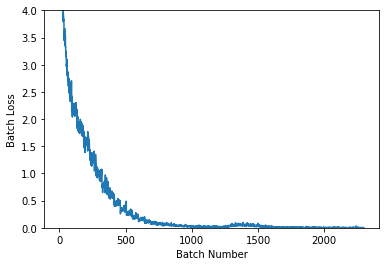

In [11]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6), dpi=200)
plt.plot(batch_loss.logs)
plt.ylim([0, 4])
plt.xlabel('Batch Number')
plt.ylabel('Batch Loss')


In [18]:
translator = train.Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [19]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from player
select count ( * ) from player

Wall time: 169 ms


In [20]:
test = list(handlr.df_test['question'].values)

input_text = tf.constant(test)

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from department where division = "as"
select count ( * ) from customer_orders where order_details = "second : transactions )



In [21]:
query = handlr.df_test['query'].values

In [22]:
train.exact_match_accuracy(query,result)

Accuracy is 45.67 %


In [17]:
# run_2022_04_25-13_08_09

In [26]:
# def exact_match_accuracy(query,result):
#     count = 0
#     for i in range(len(query)):
#         pred = result['text'][i].numpy().decode().lower().replace(' ','')
#         act = query[i].lower().replace(' ','')
#         print('Input',test[i])
#         print('Actual',query[i])
#         print('Pred',result['text'][i].numpy().decode())
#         if pred == act:
#             count = count +1
#     print("Accuracy is {:.2f} %".format(count*100/len(query)))

In [27]:
# exact_match_accuracy(query,result)

Input How many team franchises are active, with active value 'Y'?
Actual SELECT count(*) FROM team_franchise WHERE active = 'Y';
Pred select count ( * ) from department where division = "as"
Input How many products are never booked with amount higher than 200?
Actual SELECT count(*) FROM Products_for_hire WHERE product_id NOT IN ( SELECT product_id FROM products_booked WHERE booked_amount  >  200 )
Pred select count ( * ) from customer_orders where order_details = "second : transactions )
Input What are the first and last names of all customers with between 1000 and 3000 dollars outstanding?
Actual SELECT first_name ,  last_name FROM Customers WHERE amount_outstanding BETWEEN 1000 AND 3000;
Pred select first_name , last_name from customers; where main_industry = 'banking'
Input What is the nickname of staff with first name as Janessa and last name as Sawayn?
Actual SELECT nickname FROM Staff WHERE first_name = "Janessa" AND last_name = "Sawayn";
Pred select nickname from staff where fi